In [ ]:
#Import libraries#

In [33]:
from torchvision import transforms, datasets, models
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torch.optim as optim
import zipfile
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

#Transforms and DataLoader/Augmentation#

In [3]:
zip_file_path = '/content/medicalData.zip'
target_dir = '/content/dataset'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(target_dir)

print("Extraction done!")

Extraction done!


In [7]:
# Augmentation + transformations for the training data
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),  #
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [8]:
base_dir = '/content/dataset/data'

# Training data
train_dir = os.path.join(base_dir, 'train')
train_dataset = ImageFolder(train_dir, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Testing data
test_dir = os.path.join(base_dir, 'test')
test_dataset = ImageFolder(test_dir, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print("Training and testing datasets are loaded.")

Training and testing datasets are loaded.


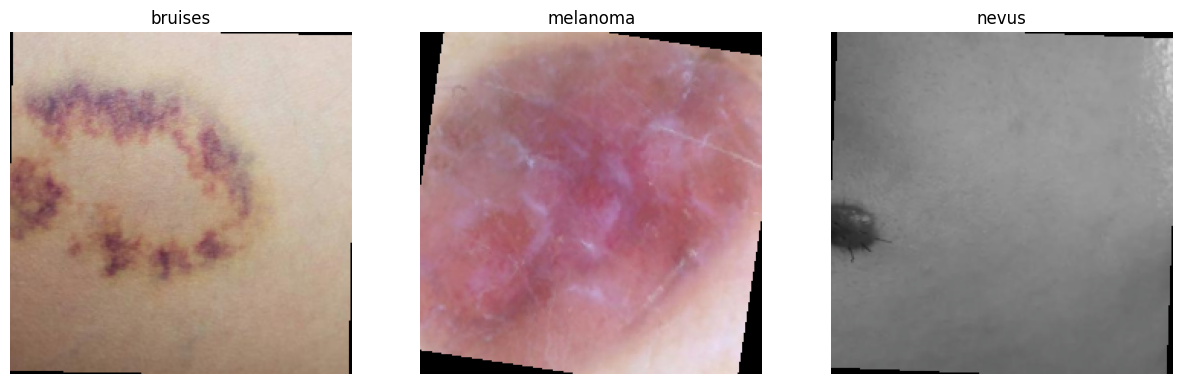

In [32]:
# Function to unnormalize and display an image
def imshow(img, ax=None):
    """Imshow for Tensor."""
    img = img.cpu().numpy().transpose((1, 2, 0))  # transpose back to height*width*channels
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # unnormalize
    img = np.clip(img, 0, 1)  # clip any values outside the range [0,1]
    if ax is None:
        ax = plt.gca()
    ax.imshow(img)
    ax.axis('off')

class_names = train_dataset.classes
class_images = {class_name: None for class_name in class_names}

# Load images, making sure to get one per class
for images, labels in train_loader:
    for image, label in zip(images, labels):
        class_name = class_names[label]
        if class_images[class_name] is None:
            class_images[class_name] = image
        # Check if we have one image for each class
        if all(class_images[class_name] is not None for class_name in class_names):
            break
    if all(class_images[class_name] is not None for class_name in class_names):
        break

# Make sure we're only plotting if we have all the images
if not all(class_images[class_name] is not None for class_name in class_names):
    print("Could not find an image for each class.")
else:
    # Plot the images
    fig = plt.figure(figsize=(15, 5))
    for i, (class_name, image) in enumerate(class_images.items()):
        ax = fig.add_subplot(1, len(class_names), i + 1, xticks=[], yticks=[])
        imshow(image, ax=ax)
        ax.set_title(class_name)
    plt.show()

#Initializing & modify Model#

In [9]:
model = models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 154MB/s]


In [12]:
# Modify the classifier to fit the 3-class problem
num_features = model.classifier[6].in_features
features = list(model.classifier.children())[:-1]
features.extend([nn.Linear(num_features, 3)])
model.classifier = nn.Sequential(*features)

for param in model.features.parameters():
    param.requires_grad = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)

epochs = 20

#Training#

In [17]:
train_losses = []
train_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Predictions
        _, preds = torch.max(outputs, 1)

        # Calculate loss
        loss = criterion(outputs, labels)

         # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct_predictions += torch.sum(preds == labels).item()
        total_predictions += labels.size(0)

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct_predictions / total_predictions

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

Epoch 1/20, Loss: 0.1194, Accuracy: 0.9671
Epoch 2/20, Loss: 0.0921, Accuracy: 0.9671
Epoch 3/20, Loss: 0.1066, Accuracy: 0.9588
Epoch 4/20, Loss: 0.1158, Accuracy: 0.9609
Epoch 5/20, Loss: 0.1219, Accuracy: 0.9547
Epoch 6/20, Loss: 0.0675, Accuracy: 0.9794
Epoch 7/20, Loss: 0.0842, Accuracy: 0.9733
Epoch 8/20, Loss: 0.0924, Accuracy: 0.9733
Epoch 9/20, Loss: 0.1153, Accuracy: 0.9568
Epoch 10/20, Loss: 0.1321, Accuracy: 0.9568
Epoch 11/20, Loss: 0.0961, Accuracy: 0.9630
Epoch 12/20, Loss: 0.0642, Accuracy: 0.9794
Epoch 13/20, Loss: 0.1038, Accuracy: 0.9609
Epoch 14/20, Loss: 0.1161, Accuracy: 0.9630
Epoch 15/20, Loss: 0.1309, Accuracy: 0.9568
Epoch 16/20, Loss: 0.1083, Accuracy: 0.9630
Epoch 17/20, Loss: 0.1142, Accuracy: 0.9568
Epoch 18/20, Loss: 0.0709, Accuracy: 0.9733
Epoch 19/20, Loss: 0.0392, Accuracy: 0.9877
Epoch 20/20, Loss: 0.0543, Accuracy: 0.9815


#Testing#

In [18]:
model.eval()

running_loss = 0.0
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)


average_loss = running_loss / len(test_loader)
accuracy = correct_predictions / total_predictions

print(f'Test Loss: {average_loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%')

Test Loss: 0.1049, Test Accuracy: 97.36%


In [37]:
running_loss = 0.0
correct_predictions = 0
total_predictions = 0

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Predictions
        _, predicted = torch.max(outputs.data, 1)

        # Correct predictions
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        # Append batch predictions and labels to the list for classification report
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


average_loss = running_loss / len(test_loader)
accuracy = correct_predictions / total_predictions


all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

In [38]:
print(f'Test Loss: {average_loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%')

Test Loss: 0.1049, Test Accuracy: 97.36%


In [39]:
report = classification_report(all_labels, all_preds, target_names=train_dataset.classes)
print(report)

              precision    recall  f1-score   support

     bruises       0.98      0.98      0.98       257
    melanoma       0.93      0.97      0.95        68
       nevus       1.00      0.88      0.93        16

    accuracy                           0.97       341
   macro avg       0.97      0.94      0.96       341
weighted avg       0.97      0.97      0.97       341



#Plot Training Loss & Accuracy#

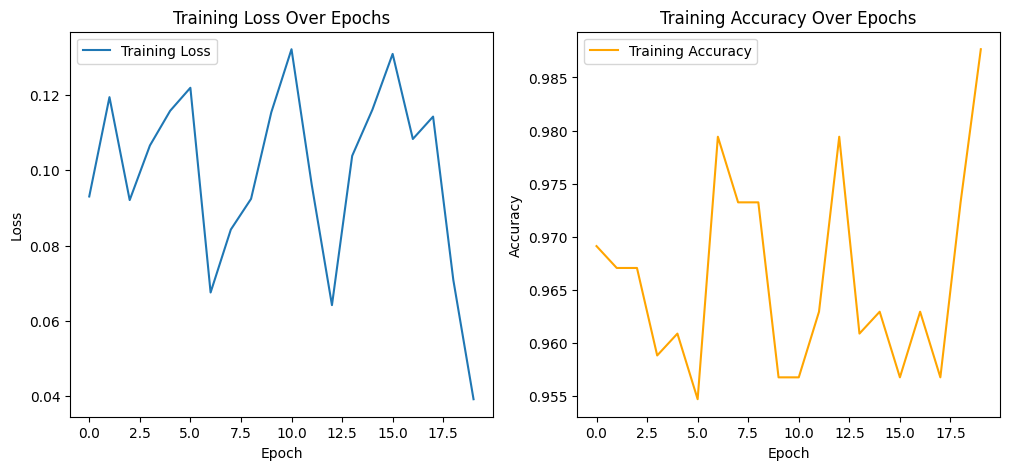

In [21]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.legend()

plt.show()